### Setup Colab

In [ ]:
# %load_ext autoreload
# %autoreload 2
# #colab config
# from google.colab import drive

# drive.mount('/content/drive')

# import os

# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'NYU ML'

# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# os.chdir(GOOGLE_DRIVE_PATH)

# print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/My Drive/NYU ML


In [ ]:
# !pip install gcsfs==2024.9.0.post1 fsspec==2024.9.0
# !pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: gcsfs
    Found existing installation: gcsfs 2024.10.0
    Uninstalling gcsfs-2024.10.0:
      Successfully uninstalled gcsfs-2024.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.8 MB/s eta 0:00:00


# Import

In [2]:
from datasets import load_dataset
import numpy as np
import math
import matplotlib.pyplot as plt


### Load Data

In [3]:
total_dataset = load_dataset("MissTiny/WikiArt",cache_dir="data")

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/60 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
total_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'image_numpy', 'CLIPVisionModelWithProjection_image_embeds'],
        num_rows: 57529
    })
    test: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'image_numpy', 'CLIPVisionModelWithProjection_image_embeds'],
        num_rows: 19177
    })
})

In [138]:
X_train = np.array(total_dataset['train']['embeddings_pca512'])
y_train = total_dataset['train']['date']
y_train = np.array([int(year) for year in y_train], dtype = int) # year int

X_test = np.array(total_dataset['test']['embeddings_pca512'])
y_test = total_dataset['test']['date']
y_test = np.array([int(year) for year in y_test])

filter_mask = (y_train > 1800) & (y_train <2000)
X_train = X_train[filter_mask]
y_train = y_train[filter_mask]

filter_mask = (y_test > 1800) & (y_test <2000)
X_test = X_test[filter_mask]
y_test = y_test[filter_mask]


min_year = min(min(y_train), min(y_test))
max_year = max(max(y_train), max(y_test))
range_year = max_year - min_year
interval_year = 10
num_c = math.ceil(range_year / interval_year)
year_book = np.linspace(min_year, min_year+num_c*interval_year, num_c+1, dtype = int)


In [139]:
mini_data_size = 10000
X_mini = X_train[:mini_data_size]
y_mini = y_train[:mini_data_size]


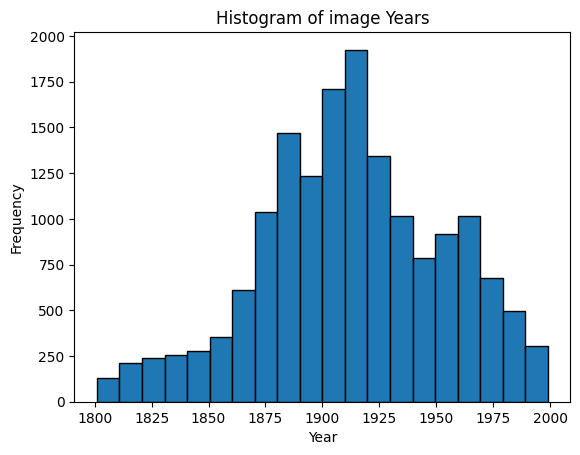

In [140]:
plt.hist(y_test, bins=num_c, edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of image Years')

# Display the histogram
plt.show()

In [113]:
# year string to 1 hot code
def date_to_1hot(y, interval_year = interval_year, range_year = range_year, min_year=min_year, max_year=max_year):
    num_item = y.shape[0]
    num_features = math.ceil(range_year / interval_year)
    
    y_label = np.zeros((num_item, num_features))
    for i in range(num_item):
        index = (y[i] - min_year) // interval_year
        y_label[i][index] = 1
    
    return y_label

# year int to class
def date_to_class(y, interval_year = interval_year, range_year = range_year, min_year=min_year, max_year=max_year, year_book = year_book):
    y_class = np.zeros_like(y)
    for i in range(y_class.shape[0]):
        y_class[i] = (y[i] - min_year)//interval_year
    return y_class

def date_floor(y, interval_year = interval_year, range_year = range_year, min_year=min_year, max_year=max_year, year_book = year_book):
    y_class = np.zeros_like(y)
    for i in range(y_class.shape[0]):
        y_class[i] = (y[i] - min_year)//interval_year*interval_year + min_year
    return y_class



## Random forest classifier


Overfit Mini dataset

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [116]:
y_mini_label = date_to_1hot(y_mini)

In [117]:
# Assuming X_train, y_train are your training data and X_test, y_test are your test data
# RandomForest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
classifier.fit(X_mini, y_mini_label)

# Make predictions
y_mini_pred_rf = classifier.predict(X_mini)

In [118]:
# Evaluate accuracy
accuracy = accuracy_score(y_mini_label, y_mini_pred_rf)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9986


The whole dataset

In [119]:
y_train_label = date_to_1hot(y_train)
y_test_label = date_to_1hot(y_test)

In [120]:
# Assuming X_train, y_train are your training data and X_test, y_test are your test data
# RandomForest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
classifier.fit(X_train, y_train_label)

# Make predictions
y_pred_rf = classifier.predict(X_test)

In [121]:
accuracy_rf = accuracy_score(y_test_label, y_pred_rf)
print(f'Accuracy: {accuracy_rf}')

Accuracy: 0.0036502059759086405


# XGBoost

In [124]:
y_mini_f = date_floor(y_mini)
print(y_mini_f)

[1910 1900 1930 ... 1950 1930 1850]


In [125]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_mini_f)
y_mini_le = le.transform(y_mini_f)

In [126]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the XGBoost model for multi-class classification
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Specify multi-class classification
    num_class=num_c,               # Set the number of classes
    eval_metric='mlogloss'      # Log loss metric for multi-class
)



# Train the model
model.fit(X_mini, y_mini_le)

# Make predictions
y_mini_xg = model.predict(X_mini)

y_mini_f_xg =le.inverse_transform(y_mini_xg) 

# Evaluate the model
accuracy = accuracy_score(y_mini_f_xg, y_mini_f)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9999


### Whole dataset

In [143]:
y_train_f = date_floor(y_train)
y_test_f = date_floor(y_test)

le = LabelEncoder()
le.fit(y_train_f)
y_train_le = le.transform(y_train_f)


In [144]:
def recalculate_accuracy(y_pre, y_test):
    np.isin(y_pre, y_test)    
    return accuracy_score(y_pre[mask], y_test[mask])


In [145]:
# Define the XGBoost model for multi-class classification
model0 = xgb.XGBClassifier(
    objective='multi:softmax',  # Specify multi-class classification
    num_class=len(le.classes_),               # Set the number of classes
    eval_metric='mlogloss'      # Log loss metric for multi-class
)



# Train the model
model0.fit(X_train, y_train_le)

# Make predictions
# y_test_xg = model.predict(y_test)
y_test_xg = model0.predict(X_test)

# y_test_f_xg = le.inverse_transform(y_test_xg)
y_test_f_xg = le.inverse_transform(y_test_xg)

# Evaluate the model
accuracy = accuracy_score(y_test_f_xg, y_test_f)
print(f'Accuracy: {accuracy}')

Accuracy: 0.20907556722295143


In [146]:
y_test_xg = model0.predict(X_test)

# y_test_f_xg = le.inverse_transform(y_test_xg)
y_test_f_xg = le.inverse_transform(y_test_xg)

# Evaluate the model
accuracy = accuracy_score(y_test_f_xg, y_test_f)
print(f'Accuracy: {accuracy}')

Accuracy: 0.20907556722295143


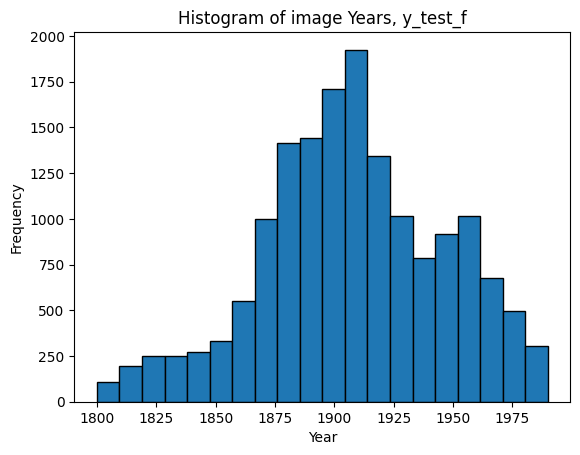

In [147]:
plt.hist(y_test_f, bins=num_c, edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of image Years, y_test_f')

# Display the histogram
plt.show()

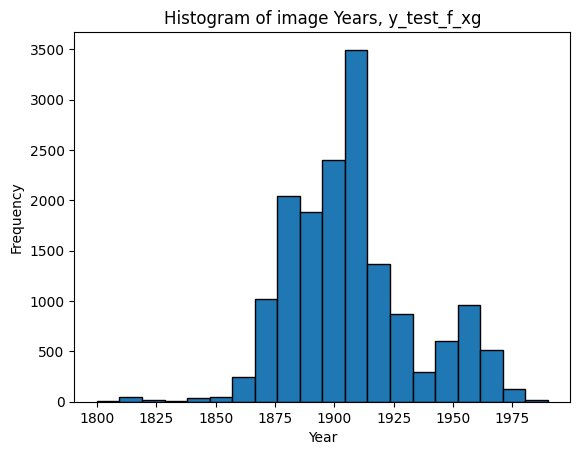

In [148]:
plt.hist(y_test_f_xg, bins=num_c, edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of image Years, y_test_f_xg')

# Display the histogram
plt.show()